In [1]:
import sys; sys.path.append('../')

import pickle
import glob
from src.utils.visualization import plot_trues
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
from numpy import nanmean

oversamplers = glob.glob('./results/case2/*.pickle')

In [2]:
plt.rcParams["figure.figsize"] = (20,10)
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 22})

In [3]:
@interact
def fn(ov=oversamplers):
    with open(ov, 'rb') as fh:
        res = pickle.load(fh)

    ground_truth = res['ground_truth']
    labels = res['labels']
    plot_trues(
        tps=res['tps'], tps_tfs=res['tp_tfs'], gt=ground_truth,
        labels=labels, tps_err=res['tps_err'], tps_tfs_err=res['tp_tfs_err']
    )
    name = ov.split('/')[-1][:-7]
    plt.title(name)
    plt.yscale('log')
    plt.savefig(name + '.png', bbox_inches='tight')

interactive(children=(Dropdown(description='ov', options=('./results/case2/SMOBD.pickle', './results/case2/Ass…

In [35]:
def load_pickle(pickle_path):
    try:
        with open(pickle_path, 'rb') as fh:
            return pickle.load(fh)
    except:
        return [{'mean_test_score': [0,0]}]
    
def custom_metric_from_pickle(pickle_path):
    res = load_pickle(pickle_path)
    tp = np.array(res['tps'])
    tp_fn = np.ones(len(tp)) * res['ground_truth']
    tp_fp = np.array(res['tp_tfs'])
    recall = tp  / tp_fn
    precision = tp / tp_fp
    return recall * 0.7 + precision * 0.3

/home/nicolas/.local/share/virtualenvs/point-cloud-learn-qCE1QqFz/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


(0, 0.7)

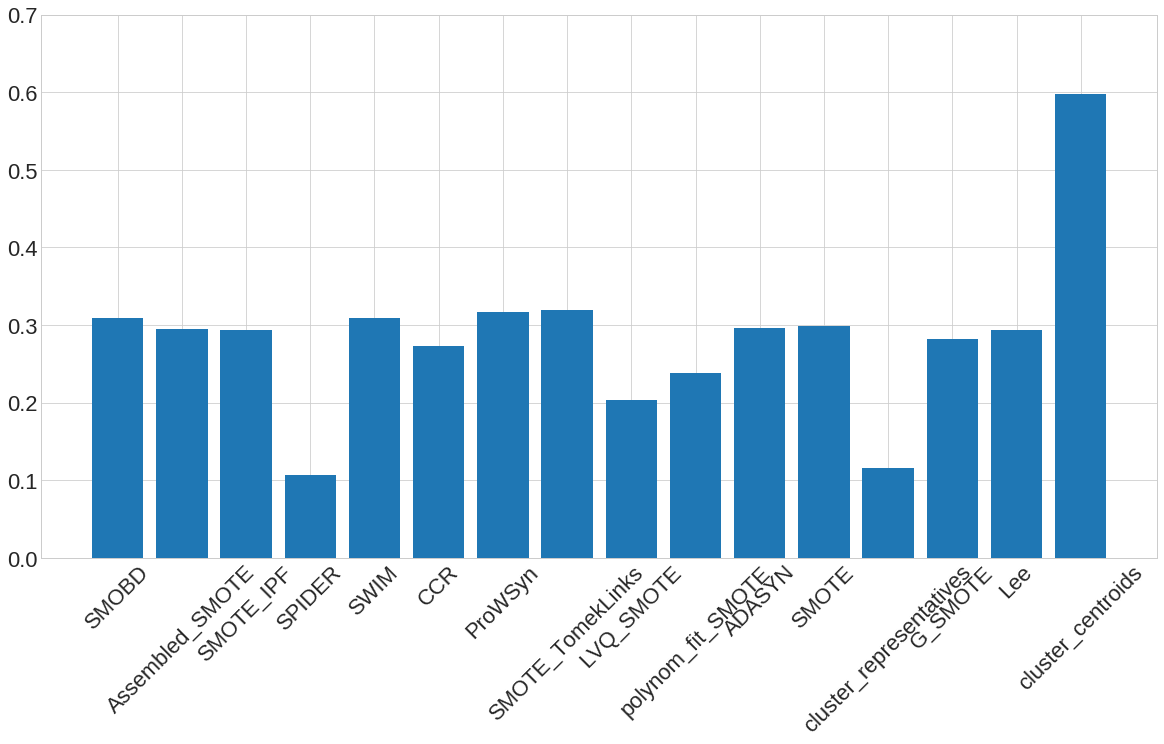

In [36]:
y = [np.nanmean(custom_metric_from_pickle(ov)) for ov in oversamplers if not 'BASELINE' in ov]
yerr = [np.nanstd(custom_metric_from_pickle(ov)) for ov in oversamplers if not 'BASELINE' in ov]
labels = [ov.split('/')[-1][:-7] for ov in oversamplers if not 'BASELINE' in ov]

plt.bar(range(len(y)), y)
plt.xticks(range(len(y)), labels, rotation=45)
plt.ylim((0, 0.7))

In [41]:
max(custom_metric_from_pickle('./results/case2/BASELINE.pickle'))

/home/nicolas/.local/share/virtualenvs/point-cloud-learn-qCE1QqFz/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


0.542786561264822

In [6]:
for f in glob.glob('../experiments/model_selection/results/*.pickle'):
    if 'results' in f.split('/')[-1]: continue
    try:
        with open(f, 'rb') as fh:
            print(f'\n{"-"*6}{f}{"-"*6}\n', pickle.load(fh), '\n')
    except:
        print(f)


------../experiments/model_selection/results/RandomForestClassifier-ClusterCentroids.pickle------
 {'RandomForestClassifier__criterion': 'entropy', 'RandomForestClassifier__n_estimators': 100} 


------../experiments/model_selection/results/LinearDiscriminantAnalysis-SMOTETomekLinksDecorator.pickle------
 {'LinearDiscriminantAnalysis__shrinkage': 'auto', 'LinearDiscriminantAnalysis__solver': 'eigen'} 


------../experiments/model_selection/results/XGBClassifier-ClusterCentroids.pickle------
 {'XGBClassifier__booster': 'gblinear', 'XGBClassifier__learning_rate': 0.1, 'XGBClassifier__n_estimators': 50} 


------../experiments/model_selection/results/LinearDiscriminantAnalysis-ClusterCentroids.pickle------
 {'LinearDiscriminantAnalysis__shrinkage': 'auto', 'LinearDiscriminantAnalysis__solver': 'eigen'} 


------../experiments/model_selection/results/AdaBoostClassifier-ClusterCentroids.pickle------
 {'AdaBoostClassifier__base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=

../experiments/model_selection/results/LinearDiscriminantAnalysis SMOTETomekLinksDecorator-results.pickle 0.6919758162394749
../experiments/model_selection/results/XGBClassifier ClusterCentroids-results.pickle 0.6959916583507989
../experiments/model_selection/results/AdaBoostClassifier ClusterCentroids-results.pickle 0.6895476132573903
../experiments/model_selection/results/DecisionTreeClassifier ClusterCentroids-results.pickle 0.6676084131083352
../experiments/model_selection/results/KNeighborsClassifier ClusterCentroids-results.pickle 0.6983561430701726
../experiments/model_selection/results/GaussianNB ClusterCentroids-results.pickle 0.6659205585643047
../experiments/model_selection/results/SVC ClusterCentroids-results.pickle 0.6738162503768304
../experiments/model_selection/results/RandomForestClassifier ClusterCentroids-results.pickle 0.6828195236316799


(0.65, 0.73)

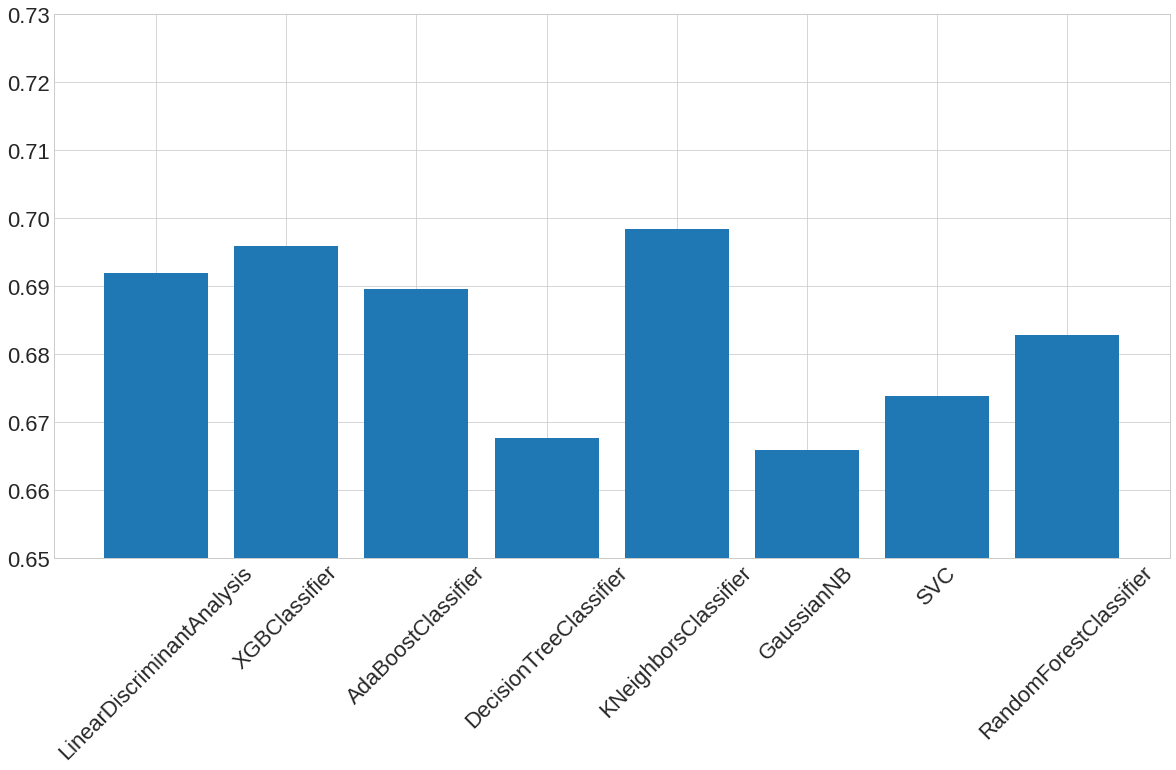

In [16]:
res = {}
for f in glob.glob('../experiments/model_selection/results/*.pickle'):
    if not 'results' in f.split('/')[-1]: continue
    try:
        with open(f, 'rb') as fh:
            results = pickle.load(fh)[0]
        name, resampler = f.split('-', 1)
        res[name] = res.get(name, []) + [{'resampler': resampler, **results}]
    except Exception as e:
        print(e, f)
bests = []
labels = []
finals = []
for model, runs in res.items():
    best_resampler_i = np.argmax([nanmean(runs[0]['mean_test_score']), nanmean(runs[1]['mean_test_score'])])
    best_resampler = runs[best_resampler_i]['resampler']
    score = nanmean(runs[best_resampler_i]['mean_test_score'])
    bests.append(score)
    labels.append(model.split('/')[-1])
    finals.append(model + '-' + best_resampler)
    print(model, best_resampler, score)
    
plt.bar(range(len(bests)), bests)
plt.xticks(range(len(bests)), labels, rotation = 45)
plt.ylim((0.65,.73))

In [28]:
import pandas as pd
print(pd.Series(bests, index=labels).sort_values(ascending=False).to_csv())

KNeighborsClassifier,0.6983561430701726
XGBClassifier,0.6959916583507989
LinearDiscriminantAnalysis,0.6919758162394749
AdaBoostClassifier,0.6895476132573903
RandomForestClassifier,0.6828195236316799
SVC,0.6738162503768304
DecisionTreeClassifier,0.6676084131083352
GaussianNB,0.6659205585643047



/home/nicolas/.local/share/virtualenvs/point-cloud-learn-qCE1QqFz/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [9]:
labels, scores, n_features = [], [], []

for final in finals:
    f = final.replace('model_selection', 'feature_selection')
    p = f.replace('-results', '')
    try:
        with open(f, 'rb') as fh:
            results = pickle.load(fh)[0]
        with open(p, 'rb') as fh:
            opts = pickle.load(fh)
    except:
        print(f)
    name = p.rsplit('/', 1)[1]
    labels.append(name.split('-')[0])
    scores.append(results['mean_test_score'].mean())
    n_features.append(opts['FEATURE_SELECTION__k'])

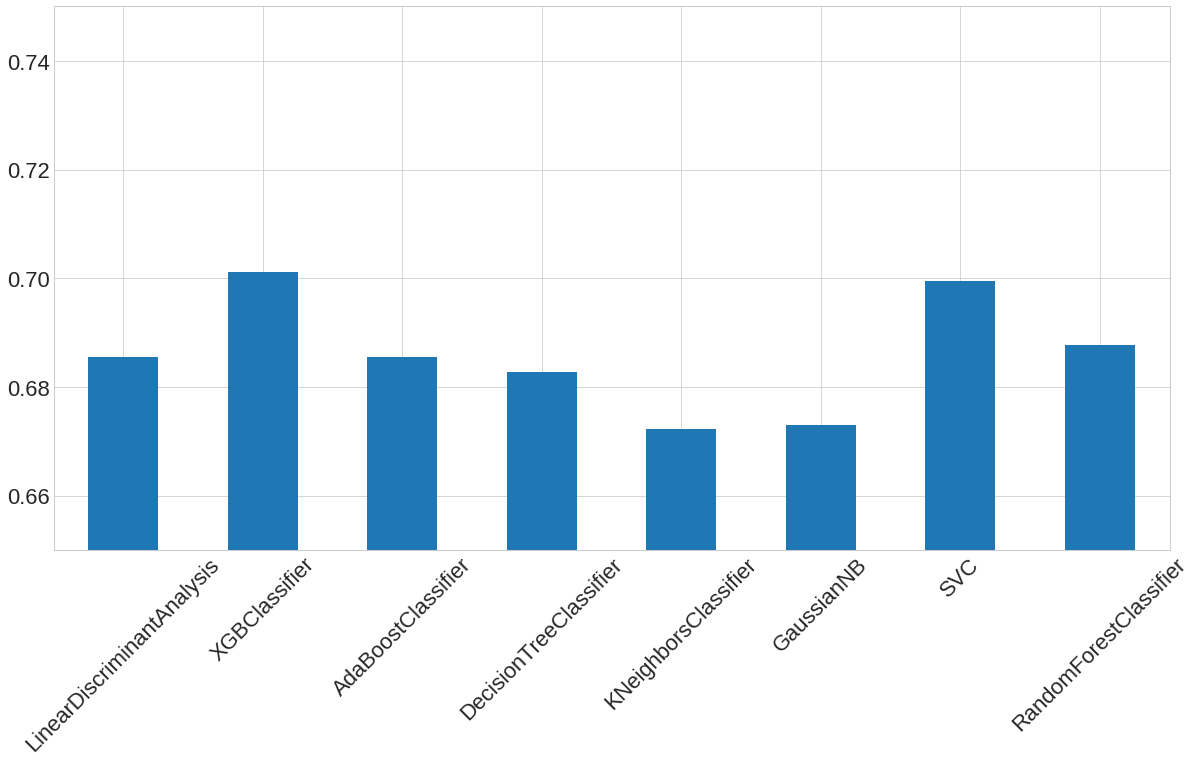

In [34]:
feat = pd.DataFrame([n_features, scores], columns = labels, index=['Number of Features', 'Score']).T

feat['Score'].plot.bar(rot=45, ylim=(0.65,0.75))

In [33]:
print(feat.sort_values('Score', ascending=False).to_csv())

,Number of Features,Score
XGBClassifier,32.0,0.7011271607387723
SVC,21.0,0.6994842608411211
RandomForestClassifier,32.0,0.6877685539735847
LinearDiscriminantAnalysis,27.0,0.6855994405697786
AdaBoostClassifier,25.0,0.6854494576049956
DecisionTreeClassifier,34.0,0.6827198284418217
GaussianNB,6.0,0.6729911003930935
KNeighborsClassifier,35.0,0.6722631955586837



In [11]:
import pandas as pd
df = pd.read_csv('../data/castellX.csv')
df

,cluster_name,x,y,z,n_points,n_order,volume,positive_volume,negative_volume,area,...,coplanararity_index_mean_origin,coplanararity_index_sigma_origin,colinearity_index_mean_origin,colinearity_index_sigma_origin,coplanararity_index_mean_destination,coplanararity_index_sigma_destination,colinearity_index_mean_destination,colinearity_index_sigma_destination,angles_mean,angles_sigma
0,10131,1.552837,-2.036651,0.331233,1.662618,0.040894,-0.251303,-0.176319,-0.213128,-0.130054,...,1.070138,-1.029291,-0.580032,-0.335227,0.848923,-0.207154,-0.610828,-0.400993,-0.835193,-0.890130
1,8120,1.017139,-1.185332,0.564500,0.979265,3.396733,0.307364,0.407319,-0.017555,3.071891,...,0.306460,0.805628,-0.500442,-0.284194,0.257370,0.368831,-0.515764,-0.344426,-0.369350,0.107835
2,8020,0.985053,-1.139540,0.464746,0.947098,0.885313,-0.143115,-0.050462,-0.193884,1.010567,...,0.696542,0.029054,-0.547837,-0.320828,0.372195,0.459178,-0.549375,-0.341126,-0.701683,-0.614245
3,7332,0.694402,-0.641345,0.937685,0.700957,0.681488,-0.187509,-0.094290,-0.213128,0.676031,...,1.169725,1.144925,-0.529450,-0.305955,1.325485,-0.477337,-0.627680,-0.412429,-0.461804,-0.623835
4,7208,0.657407,-0.587703,0.608703,0.658785,0.390309,-0.218583,-0.134246,-0.213128,0.352435,...,0.902643,0.410735,-0.515849,-0.274723,0.117296,0.044859,-0.528177,-0.304690,-0.390224,-0.782815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9030,6,-2.132804,0.998505,-0.881720,-1.805958,-0.148372,-0.034787,0.099876,-0.209917,0.043386,...,-1.623351,0.319395,1.495128,1.079808,-1.732274,0.379136,0.883443,0.420240,2.086710,1.221857
9031,4,-2.137601,1.009548,-0.888388,-1.806551,-0.148372,0.010897,0.159759,-0.211571,-0.054971,...,-0.925972,-0.790436,1.146243,0.566687,-0.982851,-0.542868,0.328216,0.078821,2.007154,0.332299
9032,3,-2.141322,0.997246,-0.894919,-1.807144,-0.162931,-0.108649,0.007113,-0.213128,-0.264681,...,-1.070914,-0.608643,0.576606,0.072694,-1.431787,0.724155,1.899763,1.208390,1.451648,2.148381
9033,2,-2.140512,0.950513,-0.974873,-1.807366,-0.162931,-0.098416,0.020271,-0.213128,-0.223429,...,-1.288563,-0.000013,0.718828,0.294930,-1.532949,0.253968,0.311419,0.378766,0.844077,1.677594
